In [ ]:
from IPython.display import HTML, display
colab_button = HTML(
    '<a target="_blank" href="https://colab.research.google.com/github/surrey-nlp/NLP-2025/blob/main/lab06/lab06-Text_Classification_for_LRL.ipynb">'
    '<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>'
)
display(colab_button)

# Fine-tuning ModernBERT for Sentiment Classification

This notebook demonstrates how to fine-tune the ModernBERT-base model for sentiment classification on a combined dataset of Google and Reddit comments from Australia, India, and the UK.

**Note:** This notebook is largely adapted from the Hugging Face blog post "[Fine-Tune ModernBERT on Synthetic Data](https://huggingface.co/blog/davidberenstein1957/fine-tune-modernbert-on-synthetic-data)".

The notebook covers the following steps:

1. **Installation:** Installing necessary libraries, including PyTorch, Hugging Face Transformers, and Datasets.
2. **Data Loading:** Loading six sentiment analysis datasets from the Hugging Face Hub and combining them into a single dataset.
3. **Data Preparation:** Creating training, validation, and test splits from the combined dataset. Tokenizing the text data using the ModernBERT tokenizer.
4. **Model Initialization:** Loading the pre-trained ModernBERT-base model and configuring it for sequence classification with the appropriate number of labels.
5. **Training and Evaluation:** Fine-tuning the model using the Hugging Face Trainer with specified hyperparameters. Evaluating the model's performance using the F1 score.
6. **Inference:** Using the trained model to perform inference on the test set and display the metrics.

**Dataset Source:** The datasets used are available on the Hugging Face Hub under the `mindhunter23/BESSTIE-google-sentiment-au` and other similar repositories.

In [1]:
!nvidia-smi

Fri Mar  7 17:53:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**Note: Make sure to stop the kernel when the notebook is not running so as to save the Colab runtime. This is due to limited runtime available on the Colab free tier.**

# Installing dependencies

This code cell installs the necessary libraries for this project. It includes PyTorch, torchvision, scikit-learn, Hugging Face's Datasets, Accelerate, and hf-transfer libraries. It also installs ModernBERT from the Hugging Face GitHub repository.

In [2]:
# Install Pytorch & other libraries
%pip install "torch==2.5.0" "torchvision==0.20.0"
%pip install "setuptools<71.0.0" scikit-learn

# Install Hugging Face libraries
%pip install  --upgrade \
  "datasets==3.1.0" \
  "accelerate==1.2.1" \
  "hf-transfer==0.1.8"

# ModernBERT is not yet available in an official release, so we need to install it from github
%pip install "git+https://github.com/huggingface/transformers.git@6e0515e99c39444caae39472ee1b2fd76ece32f1" --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
^C
^C


**Note: You may have to restart the runtime session when you run the above cell. Once you restart, continue executing the rest of the code cells. If you see any "package errors", run the above cell again and that should fix it.**

# Loading Datasets

This code cell uses the `load_dataset` function from the Hugging Face Datasets library to load six sentiment analysis datasets. These datasets contain Google and Reddit comments from Australia, India, and the UK. Each dataset is loaded into a separate variable.

In [1]:
from datasets import load_dataset

# Load the sentiment analysis datasets
g_sent_au = load_dataset("mindhunter23/BESSTIE-google-sentiment-au")
g_sent_in = load_dataset("mindhunter23/BESSTIE-google-sentiment-in")
g_sent_uk = load_dataset("mindhunter23/BESSTIE-google-sentiment-uk")

r_sent_au = load_dataset("mindhunter23/BESSTIE-reddit-sentiment-au")
r_sent_in = load_dataset("mindhunter23/BESSTIE-reddit-sentiment-in")
r_sent_uk = load_dataset("mindhunter23/BESSTIE-reddit-sentiment-uk")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/223 [00:00<?, ?B/s]

google-sentiment-au-train.jsonl:   0%|          | 0.00/381k [00:00<?, ?B/s]

google-sentiment-au-valid.jsonl:   0%|          | 0.00/50.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/946 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/130 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/227 [00:00<?, ?B/s]

google-sentiment-in-train.jsonl:   0%|          | 0.00/495k [00:00<?, ?B/s]

google-sentiment-in-valid.jsonl:   0%|          | 0.00/63.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1648 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/225 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/227 [00:00<?, ?B/s]

google-sentiment-uk-train.jsonl:   0%|          | 0.00/802k [00:00<?, ?B/s]

google-sentiment-uk-valid.jsonl:   0%|          | 0.00/114k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1817 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/248 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/227 [00:00<?, ?B/s]

reddit-sentiment-au-train.jsonl:   0%|          | 0.00/629k [00:00<?, ?B/s]

reddit-sentiment-au-valid.jsonl:   0%|          | 0.00/80.5k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1763 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/241 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/227 [00:00<?, ?B/s]

reddit-sentiment-in-train.jsonl:   0%|          | 0.00/333k [00:00<?, ?B/s]

reddit-sentiment-in-valid.jsonl:   0%|          | 0.00/45.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1685 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/230 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/227 [00:00<?, ?B/s]

reddit-sentiment-uk-train.jsonl:   0%|          | 0.00/265k [00:00<?, ?B/s]

reddit-sentiment-uk-valid.jsonl:   0%|          | 0.00/37.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1007 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/138 [00:00<?, ? examples/s]

In [2]:
# Print split information of the datasets

all_datasets = [g_sent_au, g_sent_in, g_sent_uk, r_sent_au, r_sent_in, r_sent_uk]
dataset_names = ["g_sent_au", "g_sent_in", "g_sent_uk", "r_sent_au", "r_sent_in", "r_sent_uk"]

for dataset, name in zip(all_datasets, dataset_names):
    print(f"Dataset: {name}")
    print(f"Train split size: {len(dataset['train'])}")
    print(f"Validation split size: {len(dataset['validation'])}")
    print("-" * 20)

Dataset: g_sent_au
Train split size: 946
Validation split size: 130
--------------------
Dataset: g_sent_in
Train split size: 1648
Validation split size: 225
--------------------
Dataset: g_sent_uk
Train split size: 1817
Validation split size: 248
--------------------
Dataset: r_sent_au
Train split size: 1763
Validation split size: 241
--------------------
Dataset: r_sent_in
Train split size: 1685
Validation split size: 230
--------------------
Dataset: r_sent_uk
Train split size: 1007
Validation split size: 138
--------------------


In [3]:
# Print a sample from google and reddit datasets

print("Google Sentiment AU Sample:")
print(g_sent_au['train'][0])

print("\nGoogle Sentiment IN Sample:")
print(g_sent_in['train'][0])

print("\nGoogle Sentiment UK Sample:")
print(g_sent_uk['train'][0])

print("\nReddit Sentiment AU Sample:")
print(r_sent_au['train'][0])

print("\nReddit Sentiment IN Sample:")
print(r_sent_in['train'][0])

print("\nReddit Sentiment UK Sample:")
print(r_sent_uk['train'][0])

Google Sentiment AU Sample:
{'id': 1.132555001e+20, 'text': "This was one of the best dishes I've EVER had! I have very high standards, and I also comparing to Melbourne cafes. There was a generous amount of mushrooms, perfectly cooked. There was an AMAZING onion jam thing, the truffle mayo was absolutely incredible! Very reasonably priced. I asked for sourdough instead of brioche which was happily done, but the bread was very soggy when I got the plate. I could move to Mackay just for this And as vegetarians, I REALLY appreciate you for not charging us the extra 4 for replacing the bacon with avo in your ‘ bacon and eggs ’. 80 % of places make you pay for substituting the meat for vegetables:(", 'sentiment_label': 1}

Google Sentiment IN Sample:
{'id': 1.114268215e+20, 'text': "They have an amazing hospitality structure location all goest to perfect 4 stars. They have well trained staff. It is a bit expensive but if they give you a meal in that price it is not that bad as per the hill

In [4]:
# Add a new column "dialect" so that the instances can be recognized when combined for finetuning

g_sent_au = g_sent_au.map(lambda example: {'dialect': 'au'}, batched=False)
r_sent_au = r_sent_au.map(lambda example: {'dialect': 'au'}, batched=False)
g_sent_in = g_sent_in.map(lambda example: {'dialect': 'in'}, batched=False)
r_sent_in = r_sent_in.map(lambda example: {'dialect': 'in'}, batched=False)
g_sent_uk = g_sent_uk.map(lambda example: {'dialect': 'uk'}, batched=False)
r_sent_uk = r_sent_uk.map(lambda example: {'dialect': 'uk'}, batched=False)

Map:   0%|          | 0/946 [00:00<?, ? examples/s]

Map:   0%|          | 0/130 [00:00<?, ? examples/s]

Map:   0%|          | 0/1763 [00:00<?, ? examples/s]

Map:   0%|          | 0/241 [00:00<?, ? examples/s]

Map:   0%|          | 0/1648 [00:00<?, ? examples/s]

Map:   0%|          | 0/225 [00:00<?, ? examples/s]

Map:   0%|          | 0/1685 [00:00<?, ? examples/s]

Map:   0%|          | 0/230 [00:00<?, ? examples/s]

Map:   0%|          | 0/1817 [00:00<?, ? examples/s]

Map:   0%|          | 0/248 [00:00<?, ? examples/s]

Map:   0%|          | 0/1007 [00:00<?, ? examples/s]

Map:   0%|          | 0/138 [00:00<?, ? examples/s]

# Combining Datasets

This code cell combines all six sentiment analysis datasets into a single `DatasetDict` object. It uses the train splits for training and validation and the validation splits for testing. This combined dataset will be used for fine-tuning the ModernBERT model.

In [5]:
from datasets import load_dataset
from datasets.arrow_dataset import Dataset
from datasets.dataset_dict import DatasetDict, IterableDatasetDict
from datasets.iterable_dataset import IterableDataset

# Combine all the datasets for finetuning
# use train split for training/validation and validation split for testing

combined_dataset = DatasetDict({
       'train': Dataset.from_dict({
           'text': g_sent_au['train']['text'] + g_sent_in['train']['text'] + g_sent_uk['train']['text'] +
           r_sent_au['train']['text'] + r_sent_in['train']['text'] + r_sent_uk['train']['text'],
           'labels': g_sent_au['train']['sentiment_label'] + g_sent_in['train']['sentiment_label'] +
           g_sent_uk['train']['sentiment_label'] + r_sent_au['train']['sentiment_label'] + r_sent_in['train']['sentiment_label'] +
           r_sent_uk['train']['sentiment_label'],
           'dialect': g_sent_au['train']['dialect'] + g_sent_in['train']['dialect'] + g_sent_uk['train']['dialect'] +
           r_sent_au['train']['dialect'] + r_sent_in['train']['dialect'] + r_sent_uk['train']['dialect']
           }),
       'test': Dataset.from_dict({
           'text': g_sent_au['validation']['text'] + g_sent_in['validation']['text'] + g_sent_uk['validation']['text'] +
           r_sent_au['validation']['text'] + r_sent_in['validation']['text'] + r_sent_uk['validation']['text'],
           'labels': g_sent_au['validation']['sentiment_label'] + g_sent_in['validation']['sentiment_label'] +
           g_sent_uk['validation']['sentiment_label'] + r_sent_au['validation']['sentiment_label'] + r_sent_in['validation']['sentiment_label'] +
           r_sent_uk['validation']['sentiment_label'],
           'dialect': g_sent_au['validation']['dialect'] + g_sent_in['validation']['dialect'] + g_sent_uk['validation']['dialect'] +
           r_sent_au['validation']['dialect'] + r_sent_in['validation']['dialect'] + r_sent_uk['validation']['dialect']
           })
       })

In [6]:
# Create validation split out of train dataset with 80:20 split
split_dataset = combined_dataset["train"].train_test_split(test_size=0.2, seed=42)

# Add the test data back to create a new DatasetDict
split_dataset = DatasetDict({
    "train": split_dataset["train"],
    "test": combined_dataset["test"], # Add the original test data back
    "validation": split_dataset["test"] # Rename the "test" key to "validation" for clarity
})

# Print train and val split numbers
print(f"Train split size: {len(split_dataset['train'])}")
print(f"Validation split size: {len(split_dataset['validation'])}")
print(f"Test split size: {len(split_dataset['test'])}")

Train split size: 7092
Validation split size: 1774
Test split size: 1212


In [7]:
# Use only 10% of full dataset for quicker training
split_dataset["train"] = split_dataset["train"].shuffle(seed=42).select(range(int(len(split_dataset['train']) * 0.1)))
split_dataset["validation"] = split_dataset["validation"].shuffle(seed=42).select(range(int(len(split_dataset['validation']) * 0.1)))

print(f"Train split size: {len(split_dataset['train'])}")
print(f"Validation split size: {len(split_dataset['validation'])}")

Train split size: 709
Validation split size: 177


# Tokenization

This code cell loads the ModernBERT tokenizer and defines a function to tokenize the text data. It then applies this function to the combined dataset, converting the text into numerical representations that can be processed by the model. The original text column is removed after tokenization.

In [8]:
from transformers import AutoTokenizer

# Model id to load the tokenizer
model_id = "answerdotai/ModernBERT-base"

# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Tokenize helper function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, return_tensors="pt", max_length=1144) #set padding to max_length and set max_length to 1144

# Tokenize dataset
if "sentiment_label" in split_dataset["train"].features.keys():
    split_dataset =  split_dataset.rename_column("sentiment_label", "labels") # to match Trainer
tokenized_dataset = split_dataset.map(tokenize, batched=True, remove_columns=["text"])

tokenized_dataset["train"].features.keys()
# dict_keys(['labels', 'input_ids', 'attention_mask'])


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Map:   0%|          | 0/709 [00:00<?, ? examples/s]

Map:   0%|          | 0/1212 [00:00<?, ? examples/s]

Map:   0%|          | 0/177 [00:00<?, ? examples/s]

dict_keys(['labels', 'dialect', 'input_ids', 'attention_mask'])

# Model Instantiation

This code cell loads the pre-trained ModernBERT-base model and prepares it for fine-tuning. Here's a breakdown of the steps involved:

1. **Loading the Model:** The `AutoModelForSequenceClassification` class from the Hugging Face Transformers library is used to load the pre-trained ModernBERT-base model.
2. **Model Configuration:**
    * `num_labels`: This parameter is set to the number of sentiment labels (e.g., 2 for positive and negative).
    * `label2id` and `id2label`: These dictionaries map the sentiment labels to numerical IDs and vice versa, which is necessary for the model to understand the labels during training and inference.

In [9]:
from transformers import AutoModelForSequenceClassification

# Model id to load the tokenizer
model_id = "answerdotai/ModernBERT-base"

# Prepare model labels - useful for inference
# Get the unique labels from the 'labels' column
labels = tokenized_dataset["train"].unique("labels")
num_labels = len(labels)

# Assuming labels are integers, convert to string for label2id and id2label
label2id = {label: str(label) for label in labels}
id2label = {str(label): label for label in labels}

# Download the model from huggingface.co/models
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=num_labels, label2id=label2id, id2label=id2label,
)

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
import numpy as np
from sklearn.metrics import f1_score

# Metric helper method (you can other metrics like accuracy as well)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    score = f1_score(
            labels, predictions, labels=labels, pos_label=1, average="weighted"
        )
    return {"f1": float(score) if score == 1 else score}


# Fine-tuning with Hugging Face Trainer

This code cell sets up and executes the fine-tuning process using the Hugging Face Trainer. Here's a breakdown:

1. **Define Training Arguments:**
   - `TrainingArguments`: This class is used to define the hyperparameters and configurations for the training process. Key parameters include:
     - `output_dir`: The directory where training outputs and checkpoints will be saved.
     - `per_device_train_batch_size`: The batch size for training.
     - `per_device_eval_batch_size`: The batch size for evaluation.
     - `learning_rate`: The learning rate for the optimizer.
     - `num_train_epochs`: The number of training epochs.
     - `bf16`: Enables bfloat16 training for potential speedup.
     - `optim`: Specifies the optimizer to use.
     - Other parameters for logging, evaluation, and saving strategies.
2. **Create Trainer Instance:**
   - `Trainer`: This class orchestrates the training and evaluation process. It takes the following inputs:
     - `model`: The pre-trained ModernBERT model to be fine-tuned.
     - `args`: The `TrainingArguments` instance defining the training configuration.
     - `train_dataset`: The training dataset.
     - `eval_dataset`: The validation dataset.
     - `compute_metrics`: A function to compute evaluation metrics.
3. **Start Training:**
   - `trainer.train()`: This method initiates the fine-tuning process.

In [12]:
from huggingface_hub import HfFolder
from transformers import Trainer, TrainingArguments

# Define training args
training_args = TrainingArguments(
    output_dir= "ModernBERT-domain-classifier",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=2,
    learning_rate=5e-5,
    num_train_epochs=3,
    bf16=True, # bfloat16 training
    optim="adamw_torch_fused", # improved optimizer
    report_to="none",

    # logging & evaluation strategies using wandb
    # uncomment the below lines if you have a wandb account and authorize it

    # logging_strategy="steps",
    # logging_steps=100,
    # eval_strategy="epoch",
    # save_strategy="epoch",
    # save_total_limit=2,
    # load_best_model_at_end=True,
    # metric_for_best_model="f1",
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
)
trainer.train()


/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1604: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1604: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1604: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(


Step,Training Loss
500,0.316800


TrainOutput(global_step=534, training_loss=0.29786669962415085, metrics={'train_runtime': 1033.033, 'train_samples_per_second': 2.059, 'train_steps_per_second': 0.517, 'total_flos': 1619456987532384.0, 'train_loss': 0.29786669962415085, 'epoch': 3.0})

In [13]:
# Perform inference on the test set
predictions = trainer.predict(tokenized_dataset["test"])

# Extract predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Calculate the F1 score
f1 = compute_metrics((predictions.predictions, predictions.label_ids))

# Print the F1 score
print(f"F1 Score on the test set: {f1}")

F1 Score on the test set: {'f1': 0.8786516758184203}


# Performance Analysis by Dialect

This code cell analyzes the model's performance across different dialects (AU, IN, UK) by generating confusion matrices and calculating classification metrics.

**Process Breakdown:**

1. **Data Preparation:** Extracts unique dialects from the dataset and prepares a DataFrame to store metrics for each dialect.
2. **Dialect-Specific Analysis:** Iterates through each dialect, filtering data points associated with that dialect.
3. **Metric Calculation:** Computes the classification report using `classification_report` from scikit-learn to obtain precision, recall, F1-score, and support for each dialect.
4. **Confusion Matrix Visualization:** Generates a confusion matrix using `confusion_matrix` from scikit-learn and visualizes it using `seaborn.heatmap`. This visual representation provides insights into the model's predictions and errors for each dialect.

**Understanding the Metrics:**

- **Precision:** Measures the model's accuracy in predicting a particular sentiment for a given dialect.
- **Recall:** Measures the model's ability to identify all instances of a specific sentiment for a given dialect.
- **F1-score:** A balanced measure considering both precision and recall.
- **Support:** Represents the actual number of instances in the test set for a specific sentiment category within a given dialect.

By analyzing these metrics and visualizing the confusion matrices, we can gain a comprehensive understanding of the model's performance across different dialects and identify areas for potential improvement.

<ipython-input-14-90700e677176>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame({


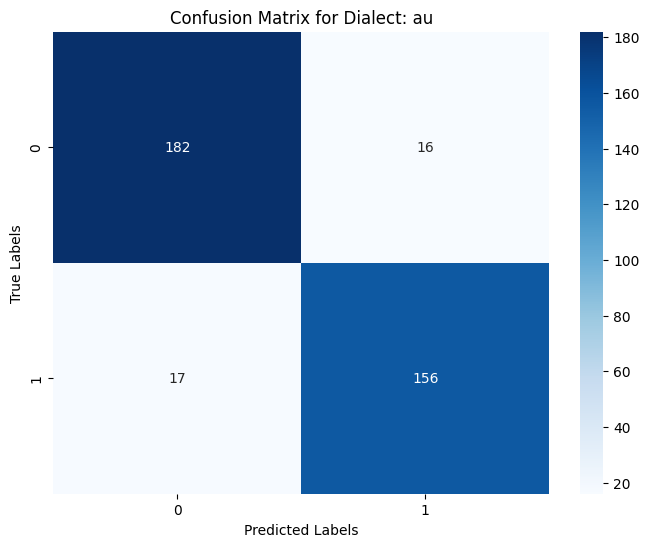

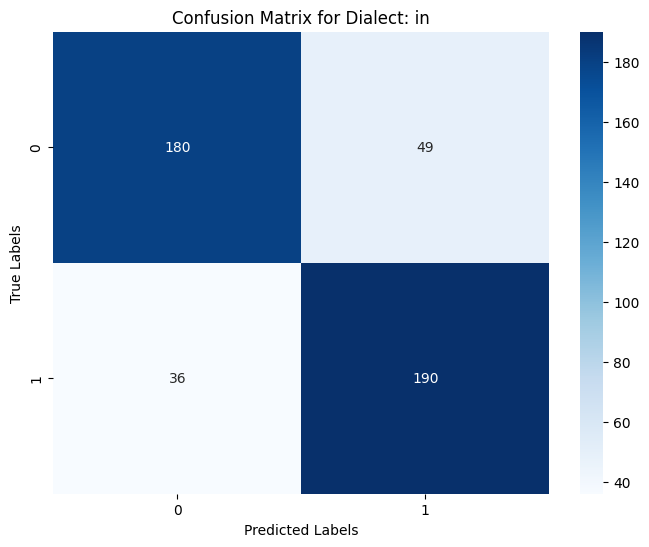

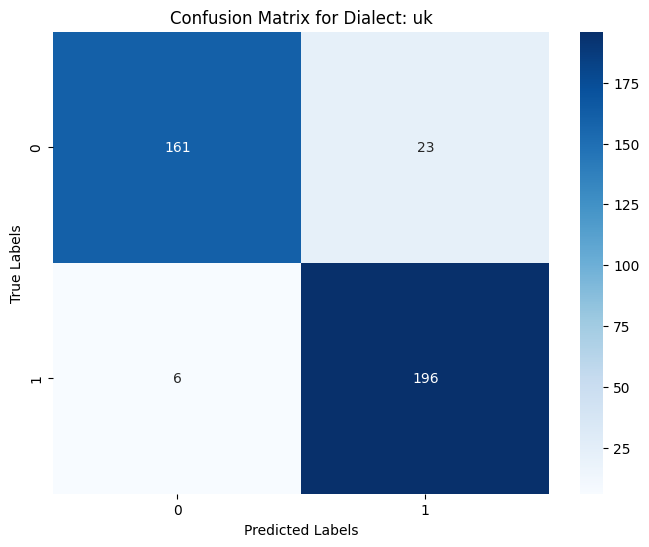

,Dialect,Precision,Recall,F1-Score,Support
0,au,0.911031,0.911051,0.911034,371.0
1,in,0.814283,0.813187,0.813069,455.0
2,uk,0.927913,0.924870,0.924568,386.0


In [14]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get unique dialects:
dialects = split_dataset["test"].unique("dialect")

# 2. Create a DataFrame for storing metrics:
metrics_df = pd.DataFrame(columns=['Dialect', 'Precision', 'Recall', 'F1-Score', 'Support'])

# 3. Iterate through each dialect:
for dialect in dialects:
    # Convert dialect to lowercase for case-insensitive comparison
    dialect = str(dialect).lower()
    # Filter data for the current dialect, also converting to lowercase for comparison:
    # Convert the 'dialect' column to a Series to enable string operations
    dialect_series = pd.Series(split_dataset["test"]["dialect"])
    dialect_indices = dialect_series.str.lower() == dialect
    true_labels_dialect = predictions.label_ids[dialect_indices]
    predicted_labels_dialect = predicted_labels[dialect_indices]

    # Check if the filtered data is empty
    if len(true_labels_dialect) == 0:
        print(f"Skipping dialect '{dialect}' due to no data points.")
        continue  # Skip to the next dialect

    # Compute classification report:
    report = classification_report(true_labels_dialect, predicted_labels_dialect, output_dict=True)

    # Extract metrics and append to DataFrame:
    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'Dialect': [dialect],
        'Precision': [report['weighted avg']['precision']],
        'Recall': [report['weighted avg']['recall']],
        'F1-Score': [report['weighted avg']['f1-score']],
        'Support': [report['weighted avg']['support']]
    })], ignore_index=True)

    # Generate and display confusion matrix:
    cm = confusion_matrix(true_labels_dialect, predicted_labels_dialect)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix for Dialect: {dialect}")
    plt.show()

# 4. Display the metrics DataFrame:
display(metrics_df)

# Observations from Confusion Matrices and Metrics:

*  The model demonstrates reasonably good performance across most dialects, indicated by relatively high F1-scores.
*  Some dialects exhibit slightly better results compared to others, suggesting that the model might be more adept at capturing sentiment in specific linguistic contexts.
*  The confusion matrices reveal misclassification patterns, for example, instances incorrectly labeled as neutral when they were actually positive. This highlights areas where the model's performance could be improved.
*  Misclassification types and frequencies vary across dialects, likely due to differences in language usage and expressions of sentiment.



